In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
%matplotlib inline

In [33]:
X = np.array([data.data[ : ,0],data.data[: ,1],data.data[: ,2]])
X = X.reshape(3,569)
y = data.target.reshape(1,569)
print("Shape of data matrix: {}".format(X.shape))
print("Shape of target vector: {}".format(y.shape))


# Manuel split
train_x = X[0:3, 0:398 ]
train_y = y[0:1, 0: 398]
test_x =  X[0:3, 398: ]
test_y =  y[0:1, 398: ]

Shape of data matrix: (3, 569)
Shape of target vector: (1, 569)


In [6]:
# Explore the dataset 
m_train = train_x.shape[1]
m_test = test_x.shape[1]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))

Number of training examples: 398
Number of testing examples: 171


## Helper functions

In [7]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z 
    return A,cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

def initialize_params_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['w' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['w' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)

    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [9]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 3     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache =  linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache =  linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [11]:

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [12]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache =  linear_activation_forward(A, parameters['W' + str(L)] ,parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [13]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost =  - np.sum(np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL)))  / m
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [14]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, cache[1])
        dA_prev, dW, db =  linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, cache[1])
        dA_prev, dW, db =  linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [16]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

In [21]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".

        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [27]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

Cost after iteration 0: 0.6930140885301452
Cost after iteration 100: 0.6859598081586793
Cost after iteration 200: 0.6783369492029321
Cost after iteration 300: 0.6689188217584288
Cost after iteration 400: 0.6558850125924918
Cost after iteration 500: 0.6405849418475765
Cost after iteration 600: 0.6273160117199147
Cost after iteration 700: 0.6174846219905369
Cost after iteration 800: 0.6109857396893058
Cost after iteration 900: 0.6046516082081552
Cost after iteration 1000: 0.6001166021773251
Cost after iteration 1100: 0.59515243910004
Cost after iteration 1200: 0.5910902037786392
Cost after iteration 1300: 0.5884959717104679
Cost after iteration 1400: 0.5794684863332049
Cost after iteration 1500: 0.5756643492227749
Cost after iteration 1600: 0.5726639387003256
Cost after iteration 1700: 0.5708807478647017
Cost after iteration 1800: 0.5683168831899216
Cost after iteration 1900: 0.5669531159921055
Cost after iteration 2000: 0.5602952220617786
Cost after iteration 2100: 0.559129803760198
Cos

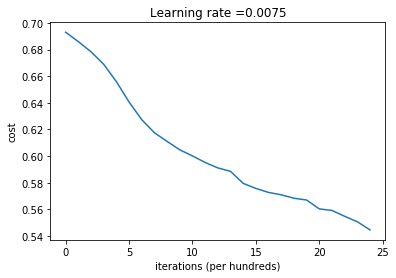

In [24]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [29]:
predictions_train = predict(test_x, test_y, parameters)

Accuracy: 0.8187134502923976
